In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
import time

In [5]:
X_train, X_val, y_train, y_val = mnist_prep()

In [6]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

In [7]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                         optimizer = "adam")

Epoch 1/10
10/10 [==============================] - 0s 14ms/step - loss: 2.1584 - accuracy: 0.2450 - val_loss: 1.9529 - val_accuracy: 0.4460
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.5613 - accuracy: 0.5980 - val_loss: 1.4080 - val_accuracy: 0.6080
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.9704 - accuracy: 0.7450 - val_loss: 0.9410 - val_accuracy: 0.7340
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5888 - accuracy: 0.8460 - val_loss: 0.7272 - val_accuracy: 0.7880
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4111 - accuracy: 0.8900 - val_loss: 0.6052 - val_accuracy: 0.8200
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.2966 - accuracy: 0.9230 - val_loss: 0.5334 - val_accuracy: 0.8340
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.9420 - val_loss: 0.5090 - val_accuracy: 0.8460
Epoch 8/10
10/10 [=

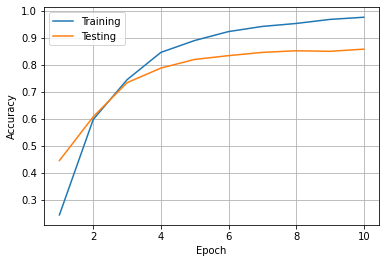

In [8]:
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 100,
                     epochs = 10)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")

In [10]:
true_acc = model.evaluate(X_val_small, y_val_small)[1]
print(true_acc)

shape_0 = model.get_weights()[0].shape
print(shape_0)

old_first_weights = model.get_weights()[0]

# first_weights = [np.random.normal(size = shape_0)]
first_weights = [model.get_weights()[0]-1]
print(first_weights)
print(first_weights[0].shape)

all_weights = first_weights + model.get_weights()[1:]
# print(all_weights)

model.set_weights(all_weights)

fake_acc = model.evaluate(X_val_small, y_val_small)[1]
print(fake_acc)

old_weights = [old_first_weights] + model.get_weights()[1:]

model.set_weights(old_weights)

old_true_acc = model.evaluate(X_val_small, y_val_small)[1]
print(old_true_acc)

16/16 [==============================] - 0s 688us/step - loss: 0.4496 - accuracy: 0.8580
0.8579999804496765
(784, 128)
[array([[-0.9825663 , -1.0448595 , -0.9829941 , ..., -1.081005  ,
        -1.039437  , -1.0173888 ],
       [-1.059742  , -1.0050594 , -0.9819378 , ..., -1.0406951 ,
        -0.95030135, -0.9664014 ],
       [-1.0499504 , -0.93690425, -1.0077294 , ..., -1.0569363 ,
        -0.9651943 , -1.0480372 ],
       ...,
       [-0.9385758 , -1.009917  , -0.9512942 , ..., -1.0546863 ,
        -0.93100244, -0.9971716 ],
       [-1.0451013 , -0.95852774, -1.0559828 , ..., -0.98283786,
        -1.0297642 , -0.90140915],
       [-1.0990843 , -0.99812406, -0.9116216 , ..., -0.9515942 ,
        -0.9846809 , -0.9902688 ]], dtype=float32)]
(784, 128)
16/16 [==============================] - 0s 626us/step - loss: 2.3433 - accuracy: 0.1340
0.1340000033378601
16/16 [==============================] - 0s 626us/step - loss: 0.4496 - accuracy: 0.8580
0.8579999804496765


In [11]:
del model

# EnKF

In [12]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [13]:
batch_size = 500
epochs = 1
particles = 2
early_stopping = 0.001
batch_normal = False
shuffle = True # noch einbauen!!!

In [14]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [15]:
delta = 0.005
h_0 = 300
epsilon = 0.005

In [16]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [17]:
X_batches = [X_train[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
y_batches = [y_train[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]

In [17]:
# start_time = time.time()

In [18]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [19]:
for p in init_model.get_weights():
    print(p.shape)
print(len(p))

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 32)
(32,)
(32, 10)
(10,)
10


In [20]:
init_model.predict(X_test)

array([[0.10160618, 0.08783221, 0.13828488, ..., 0.0517129 , 0.0964262 ,
        0.10675424],
       [0.08843368, 0.082394  , 0.14081806, ..., 0.06123935, 0.07609454,
        0.12831067],
       [0.09806038, 0.07677642, 0.12350909, ..., 0.06509114, 0.08106199,
        0.11733598],
       ...,
       [0.09138219, 0.08101669, 0.12216112, ..., 0.0673466 , 0.07430341,
        0.12863077],
       [0.10634441, 0.07812874, 0.12643099, ..., 0.06322064, 0.08886763,
        0.10894969],
       [0.09543785, 0.07998399, 0.1285082 , ..., 0.06725163, 0.08683707,
        0.11136663]], dtype=float32)

In [19]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 626us/step - loss: 2.3359 - accuracy: 0.0900


[2.3359150886535645, 0.09000000357627869]

In [22]:
weights[0]

array([[ 0.05316269,  0.01764145,  0.01522263, ...,  0.07493449,
        -0.0201476 ,  0.09051652],
       [-0.00516469,  0.07823637,  0.02811813, ..., -0.0174622 ,
        -0.02144132, -0.02854406],
       [-0.04033467,  0.00961152,  0.03930797, ..., -0.0174436 ,
         0.03845177, -0.03893438],
       ...,
       [ 0.04866969,  0.05048861, -0.01158144, ..., -0.03740012,
         0.01336047, -0.01347332],
       [ 0.01840364, -0.02679037,  0.03217081, ..., -0.0442641 ,
        -0.0488762 , -0.01088821],
       [-0.07488225, -0.07203993, -0.02490162, ...,  0.01187966,
         0.01317079,  0.01347652]], dtype=float32)

In [23]:
shapes

[array([784, 128]),
 array([128]),
 array([128, 128]),
 array([128]),
 array([128,  64]),
 array([64]),
 array([64, 32]),
 array([32]),
 array([32, 10]),
 array([10])]

In [24]:
shape_elements

array([     0, 100352, 100480, 116864, 116992, 125184, 125248, 127296,
       127328, 127648, 127658], dtype=int32)

In [20]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()

In [26]:
weights_dict["model_1"][0].shape

(784, 128)

bis hier hin passt weights_dict noch

In [21]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 626us/step - loss: 2.3586 - accuracy: 0.0960
0.09600000083446503
16/16 [==============================] - 0s 626us/step - loss: 2.3362 - accuracy: 0.0900
0.09000000357627869


Bis hier hin scheint alles gut zu sein. Verschiedene Modelle je Partikel mit den richtigen weights.

In [28]:
epoch = 1
b = 0

In [31]:
i=1

In [32]:
y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

In [33]:
y_pred_dict

{'model_1': array([[0.06636474, 0.08730603, 0.13116014, ..., 0.13296601, 0.08423506,
         0.07309815],
        [0.05952002, 0.08800955, 0.12935284, ..., 0.12457261, 0.08078581,
         0.06223412],
        [0.07510072, 0.08482299, 0.12103058, ..., 0.15330242, 0.0718178 ,
         0.08833108],
        ...,
        [0.06878649, 0.09249178, 0.11722209, ..., 0.13235511, 0.07224651,
         0.07031602],
        [0.06945327, 0.08577596, 0.11895379, ..., 0.14121774, 0.06805298,
         0.07750882],
        [0.07393224, 0.08581229, 0.12076307, ..., 0.12180146, 0.07771387,
         0.0737422 ]], dtype=float32),
 'model_2': array([[0.08334758, 0.13120623, 0.13905257, ..., 0.079992  , 0.07086264,
         0.07428858],
        [0.07410111, 0.13960594, 0.12886728, ..., 0.08622922, 0.07137077,
         0.07538734],
        [0.088851  , 0.1244102 , 0.13330148, ..., 0.07756112, 0.07555285,
         0.08117384],
        ...,
        [0.10412652, 0.11731075, 0.12585826, ..., 0.07637274, 0.0635500

In [36]:
i=1

In [37]:
jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))

In [38]:
jacobian_dict

{'model_1': array([[ -0.       ,  -0.       ,  -0.       , ...,  -0.       ,
          -0.       ,  -0.       ],
        [-15.499064 ,  -0.       ,  -0.       , ...,  -0.       ,
          -0.       ,  -0.       ],
        [ -0.       ,  -0.       ,  -0.       , ...,  -0.       ,
          -0.       ,  -0.       ],
        ...,
        [ -0.       ,  -0.       ,  -0.       , ...,  -7.2803993,
          -0.       ,  -0.       ],
        [ -0.       ,  -0.       ,  -0.       , ...,  -0.       ,
          -0.       ,  -0.       ],
        [ -0.       ,  -0.       ,  -0.       , ...,  -0.       ,
         -12.08987  ,  -0.       ]], dtype=float32),
 'model_2': array([[ -0.      ,  -0.      ,  -0.      , ...,  -0.      ,  -0.      ,
          -0.      ],
        [-12.642047,  -0.      ,  -0.      , ...,  -0.      ,  -0.      ,
          -0.      ],
        [ -0.      ,  -0.      ,  -0.      , ...,  -0.      ,  -0.      ,
          -0.      ],
        ...,
        [ -0.      ,  -0.      ,  -

In [39]:
y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
y_pred_mean

array([[0.07485616, 0.10925613, 0.13510635, ..., 0.106479  , 0.07754885,
        0.07369336],
       [0.06681056, 0.11380775, 0.12911007, ..., 0.10540092, 0.0760783 ,
        0.06881073],
       [0.08197586, 0.1046166 , 0.12716603, ..., 0.11543177, 0.07368533,
        0.08475246],
       ...,
       [0.08645651, 0.10490127, 0.12154017, ..., 0.10436392, 0.06789829,
        0.07454915],
       [0.09155034, 0.09459376, 0.12368251, ..., 0.11399061, 0.06714587,
        0.07648847],
       [0.09083405, 0.10002425, 0.12271361, ..., 0.10011293, 0.07264875,
        0.0775501 ]], dtype=float32)

In [40]:
d = np.zeros(shape = (particles, particles))
d

array([[0., 0.],
       [0., 0.]])

In [41]:
k=0

In [42]:
y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean

In [43]:
y_pred_centered

array([[-0.00849142, -0.0219501 , -0.00394621, ...,  0.02648701,
         0.00668621, -0.00059522],
       [-0.00729054, -0.02579819,  0.00024277, ...,  0.01917169,
         0.00470752, -0.00657661],
       [-0.00687514, -0.01979361, -0.00613546, ...,  0.03787065,
        -0.00186753,  0.00357862],
       ...,
       [-0.01767001, -0.01240949, -0.00431809, ...,  0.02799119,
         0.00434823, -0.00423313],
       [-0.02209707, -0.0088178 , -0.00472871, ...,  0.02722713,
         0.00090711,  0.00102035],
       [-0.01690181, -0.01421197, -0.00195054, ...,  0.02168853,
         0.00506512, -0.0038079 ]], dtype=float32)

In [44]:
j=0

In [45]:
d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))

In [46]:
d

array([[23.00683975,  0.        ],
       [ 0.        ,  0.        ]])

In [47]:
for k in range(particles):
    y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
    for j in range(particles):
        d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))

In [48]:
d

array([[ 23.00683975, -10.82749176],
       [-23.00684357,  10.82748985]])

In [49]:
np.sqrt(np.sum(d**2)) + epsilon

35.96468076371054

In [50]:
h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

In [51]:
h_t

8.341517111496486

In [52]:
j=0
i=0

In [53]:
weights_dict["model_{}".format(str(i+1))]

[array([[-0.02442957, -0.08253706,  0.06533472, ...,  0.1009049 ,
         -0.02745313,  0.06049433],
        [ 0.02250385,  0.00859564, -0.10634632, ..., -0.06338753,
          0.10255604,  0.0347475 ],
        [ 0.01036273, -0.0385828 , -0.05367718, ...,  0.03534405,
         -0.0111302 , -0.04563821],
        ...,
        [-0.01988236,  0.06089912, -0.03189735, ...,  0.01594105,
         -0.08252335, -0.05141233],
        [ 0.0723844 ,  0.01871777,  0.01808749, ...,  0.03069874,
         -0.04317818,  0.06011287],
        [ 0.00741978, -0.00682715,  0.03992448, ...,  0.05702784,
          0.01501952,  0.06621534]], dtype=float32),
 array([ 0.01506994,  0.06240517,  0.00970083, -0.14164431,  0.11062789,
        -0.08846144,  0.06360345,  0.19189918, -0.0083973 ,  0.18345977,
        -0.08549078, -0.06443703,  0.0354299 ,  0.11268251, -0.19702946,
        -0.03617391, -0.15383221, -0.06472646,  0.0845689 , -0.06914531,
        -0.07398204, -0.07987979, -0.08733968, -0.12108672,  0.105

In [54]:
w0 = weights_dict["model_{}".format(str(i+1))][0]
w1 = weights_dict["model_{}".format(str(i+1))][1]

In [55]:
w0

array([[-0.02442957, -0.08253706,  0.06533472, ...,  0.1009049 ,
        -0.02745313,  0.06049433],
       [ 0.02250385,  0.00859564, -0.10634632, ..., -0.06338753,
         0.10255604,  0.0347475 ],
       [ 0.01036273, -0.0385828 , -0.05367718, ...,  0.03534405,
        -0.0111302 , -0.04563821],
       ...,
       [-0.01988236,  0.06089912, -0.03189735, ...,  0.01594105,
        -0.08252335, -0.05141233],
       [ 0.0723844 ,  0.01871777,  0.01808749, ...,  0.03069874,
        -0.04317818,  0.06011287],
       [ 0.00741978, -0.00682715,  0.03992448, ...,  0.05702784,
         0.01501952,  0.06621534]], dtype=float32)

In [56]:
w0_new = np.reshape(w0, (1, -1)).ravel()
w1_new = np.reshape(w1, (1, -1)).ravel()

In [57]:
print(w0_new.shape)
print(w1_new.shape)
print(np.append(w0_new, w1_new).shape)

(100352,)
(128,)
(100480,)


In [58]:
a = np.array([])
a = np.append(a, np.array([1,2,3]))
a

array([1., 2., 3.])

In [59]:
np.append(np.array([]), np.array([1,2,3]))

array([1., 2., 3.])

In [60]:
for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array

In [65]:
weights_vector_dict["model_1"].shape

(127658,)

In [70]:
weights_all_ptcls = np.array(list(weights_vector_dict.values()))

In [71]:
weights_all_ptcls

array([[-0.02442957, -0.08253706,  0.06533472, ...,  0.5322625 ,
        -0.0083983 ,  0.13255249],
       [ 0.02953712,  0.04797963, -0.01230592, ..., -0.23547073,
        -0.45098421,  0.03597343]])

In [68]:
weights_all_ptcls.shape

(2, 127658)

In [72]:
weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

In [73]:
weights_all_ptcls

array([[   7.33162221,   20.09072158,  -13.58462175, ..., -122.88244755,
         -39.12852391,  -22.05681589],
       [  -7.32651498,  -20.12528088,   13.63765243, ...,  123.17925252,
          38.66913395,   22.22534661]])

In [79]:
print(weights_all_ptcls.mean(axis = 0).max())
print(weights_all_ptcls.mean(axis = 0).min())

0.40931648300458434
-0.4018188478407012


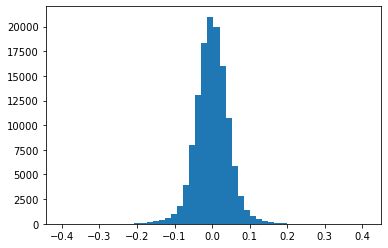

In [82]:
import matplotlib.pyplot as plt
plt.hist(weights_all_ptcls.mean(axis = 0), bins = 50)
plt.show()

In [84]:
print(weights_vector_dict["model_1"].max())
print(weights_vector_dict["model_1"].min())

0.6961262822151184
-0.48984333872795105


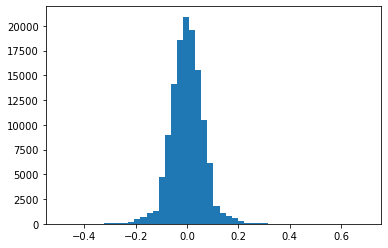

In [85]:
import matplotlib.pyplot as plt
plt.hist(weights_vector_dict["model_1"], bins = 50)
plt.show()

In [93]:
i=0
weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
weights_vector_dict["model_1"][:100352]

array([  7.33162221,  20.09072158, -13.58462175, ...,  -6.604409  ,
        -8.72771727,  -7.33215145])

In [91]:
l=0
start = shape_elements[l]
end = shape_elements[l+1]
np.reshape(weights_vector_dict["model_1"][start:end], tuple(shapes[l]))

array([[  7.33162221,  20.09072158, -13.58462175, ..., -15.12250012,
          8.32023487, -13.72896417],
       [ -2.6771153 ,  -2.2347065 ,  22.38997345, ...,  21.43133821,
        -14.64224738, -10.32087901],
       [ -4.73858178,   4.60069228,  13.9893684 , ...,  -8.60744913,
          6.90630994,   9.57770415],
       ...,
       [  3.159359  ,  -5.99637657,   4.48883412, ..., -11.15835143,
         22.20483472,  14.40680296],
       [-16.26670388,   0.54758974,  -5.97941203, ..., -13.20791209,
         17.1159155 ,  -6.680721  ],
       [  6.25457305,  -0.1688412 ,  -8.34447096, ...,  -6.604409  ,
         -8.72771727,  -7.33215145]])

In [94]:
np.reshape(weights_vector_dict["model_1"][start:end], tuple(shapes[l])).shape

(784, 128)

In [96]:
weights_dict["model_{}".format(str(i+1))][l].shape

(784, 128)

In [98]:
weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
weights_dict["model_{}".format(str(i+1))][l].shape

(784, 128)

In [99]:
for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            # set new weights for model

In [103]:
weights_dict["model_1"][0]

array([[  7.33162221,  20.09072158, -13.58462175, ..., -15.12250012,
          8.32023487, -13.72896417],
       [ -2.6771153 ,  -2.2347065 ,  22.38997345, ...,  21.43133821,
        -14.64224738, -10.32087901],
       [ -4.73858178,   4.60069228,  13.9893684 , ...,  -8.60744913,
          6.90630994,   9.57770415],
       ...,
       [  3.159359  ,  -5.99637657,   4.48883412, ..., -11.15835143,
         22.20483472,  14.40680296],
       [-16.26670388,   0.54758974,  -5.97941203, ..., -13.20791209,
         17.1159155 ,  -6.680721  ],
       [  6.25457305,  -0.1688412 ,  -8.34447096, ...,  -6.604409  ,
         -8.72771727,  -7.33215145]])

In [104]:
model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
model_dict["model_1"].get_weights()

[array([[  7.331622 ,  20.090721 , -13.584621 , ..., -15.1225   ,
           8.320235 , -13.728964 ],
        [ -2.6771152,  -2.2347064,  22.389973 , ...,  21.431337 ,
         -14.642247 , -10.320879 ],
        [ -4.7385817,   4.6006923,  13.989368 , ...,  -8.60745  ,
           6.90631  ,   9.577704 ],
        ...,
        [  3.159359 ,  -5.9963765,   4.488834 , ..., -11.158352 ,
          22.204834 ,  14.406803 ],
        [-16.266705 ,   0.5475897,  -5.979412 , ..., -13.207912 ,
          17.115915 ,  -6.680721 ],
        [  6.254573 ,  -0.1688412,  -8.344471 , ...,  -6.604409 ,
          -8.727717 ,  -7.3321514]], dtype=float32),
 array([ 12.182443  , -14.792589  ,   7.4663463 ,  16.64828   ,
        -23.117077  ,  11.026551  ,  -1.6067096 , -34.662388  ,
         -4.038332  , -26.442066  ,  10.963874  ,   9.387051  ,
          6.191957  , -15.925985  ,  44.082577  ,  13.426349  ,
         22.910797  ,  15.892112  , -14.399449  ,  11.282794  ,
          7.0014377 ,   7.217967  ,  3

In [22]:
# loop over all epochs
for epoch in range(epochs):
    # loop over all batches
    for b in range(len(X_batches)):
        for i in range(particles):
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])
            
            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
   # bis hier hin alles gut     
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
   # bis hier ok
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
                                        # d sieht recht einfach aus, aber das wird wohl stimmen
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
   # bis hier wohl ok
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
    # der Teil ist jetzt gedebugged    
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])

In [23]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_val_small, y_val_small)[1])

16/16 [==============================] - 0s 626us/step - loss: 182770448368705294303232.0000 - accuracy: 0.1080
0.1080000028014183
16/16 [==============================] - 0s 563us/step - loss: 192127721429681049698304.0000 - accuracy: 0.0940
0.09399999678134918


In [22]:
# end_time = time.time()
# print("Overall calculation took {} seconds.".format(end_time - start_time))